## Cell Smoothing / Interpolation

### Dataset
Z-stack of 2D cell microscopy images of adjacent layers. Dimension: $D \times H \times W$ ($D$: z-stack depth).

### Applications

####   2D $\rightarrow$ 3D segmentation
1. Cellpose 2D segmentation on each 2D image slice.
2. Alignment: align & stitch instances belonging to the same cell to same labels.
3.  #### I. Smoothing
    apply boundary matching (OT) (see `boundary_matching.ipynb`) to smooth adjacent layers.


#### II. Cell Interpolation
3D confocal microscopic image are usually subjected to non-uniform sampling ratio between X-Y direction and Z-direction, namely anisotropic effect, and therefore losing cell morphological information and generate "discretized" cell boundaries along z-direction. We present <u>missing layer interpolation</u> with boundary matching followed by Optimal Transport (OT). 

Example `anisotropy=4`:<br>
```
__________ - layer i

---------- -
----------  |=> interpolated "missing" layers
---------- -

__________ - layer i+1
```

In [1]:
import os
import sys
import ot
import ot.plot
import numpy as np
import matplotlib.pyplot as plt

/home/yinuo/anaconda3/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
from copy import deepcopy
from scipy import ndimage as ndi

In [3]:
from cellpose import utils as cp_utils
from cellpose import plot as cp_plot

In [4]:
sys.path.append('..')
from cellstitch.interpolate import *

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager
import seaborn as sns
from matplotlib import rcParams

sns.set_style('white')

font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'

rcParams['font.family'] = plot_font
rcParams.update({'font.size': 15})


**Util functions:**

In [6]:
def comp_match_plan(pc1, pc2):
    
    """Compute optimal matching plans between 2 sets of point clouds"""
    # compute cost matrix
    C = ot.dist(pc1, pc2).astype(np.float64)
    C /= C.max()
    
    # convert point clouds to uniform distributions
    n_pts1, n_pts2 = pc1.shape[0], pc2.shape[0]
    mu1, mu2 = np.ones(n_pts1) / n_pts1, np.ones(n_pts2) / n_pts2
    
    # compute transport plan
    plan = ot.emd(mu1, mu2, C)
    
    return plan


def interpolate(pc1, pc2, anisotropy=2):
    """
    Calculate interpolated predictions
    
    Parameters
    ----------
    pc1 : np.ndarray
        Point cloud representing cell boundary in frame 1
    
    pc2 : np.ndarray
        Point cloud representing cell boundary in frame 2
        
    anisotropy : int
        Ratio of sampling rate between different axes

    Returns
    -------
    interp_pcs : list
        Smoothed boundary locations along interpolated layers
    """
    alphas = np.linspace(0, 1, anisotropy+1)[1:-1]
    plan = comp_match_plan(pc1, pc2)
    normalized_plan = plan / plan.sum(axis=1,keepdims=1) # normalize so that the row sum is 1   
    
    interp_pcs = []
    
    for alpha in alphas:
        n_pts = pc1.shape[0]
        avg_pc = np.zeros((n_pts, 2), dtype=int)
        
        for i in range(n_pts):
            point = pc1[i]
            target_weights = normalized_plan[i]

            weighted_target = np.array([np.sum(target_weights * pc2[:, 0]),
                                   np.sum(target_weights * pc2[:, 1])])

            avg_pc[i, :] = point * (1 - alpha) + alpha * weighted_target 
            
        interp_pcs.append(avg_pc)  
        
    return interp_pcs

Visualization:

In [7]:
# reference: 
# https://pythonot.github.io/_modules/ot/plot.html#plot2D_samples_mat
def disp_match(xs, xt, G, ax, thr=1e-8, **kwargs):
    r""" Plot matrix :math:`\mathbf{G}` in 2D with lines using alpha values

    Plot lines between source and target 2D samples with a color
    proportional to the value of the matrix :math:`\mathbf{G}` between samples.


    Parameters
    ----------
    xs : ndarray, shape (ns,2)
        Source samples positions
        
    b : ndarray, shape (nt,2)
        Target samples positions
    
    G : ndarray, shape (na,nb)
        OT matrix
    
    ax : AxesSubplot
        matplotlib subplot axis
    
    thr : float, optional
        threshold above which the line is drawn
    
    **kwargs : dict
        parameters given to the plot functions (default color is black if
        nothing given)
    """

    if ('color' not in kwargs) and ('c' not in kwargs):
        kwargs['color'] = 'k'
    mx = G.max()
    for i in range(xs.shape[0]):
        for j in range(xt.shape[0]):
            if G[i, j] / mx > thr:
                ax.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                        alpha=G[i, j] / mx, **kwargs)
                
    return ax


def disp_labeled(mask, ax=None, size=(8, 8)):
    """Visualize labeled predictions from actual cell"""
    mask_labeled = cp_plot.mask_rgb(mask)
    mask_labeled[mask_labeled == 0], mask_labeled[mask_labeled == 255] = 255, 0
    
    if ax is None:
        plt.figure(figsize=size)
        plt.imshow(mask_labeled)
        plt.axis('off')
        plt.show()
        
    else:
        ax.imshow(mask_labeled)
        ax.axis('off')
        
    return ax



def disp_interp(sc_coord, tg_coord, interps, plan, show_match=False):
    """Visualize interpotations"""
    n_layers = len(interps) + 2
    alphas = np.linspace(0, 1, n_layers)
    
    fig, axes = plt.subplots(1, n_layers, figsize=(n_layers*5, 4.5))
    
    for i, ax in enumerate(axes):
        sc_color = 'w' if i == n_layers-1 else '+b'
        tg_color = 'w' if i == 0 else 'xr'
        
        ax.plot(sc_coord[:, 0], sc_coord[:, 1], sc_color, label='Source')
        ax.plot(tg_coord[:, 0], tg_coord[:, 1], tg_color, label='Target')
        if 0 < i < n_layers-1: 
            if show_match:
                ax = disp_match(sc_coord, tg_coord, plan, ax=ax, c=[.5, .5, 1])
            ax.plot(interps[i-1][:, 0], interps[i-1][:, 1], 'og', label='Interp')
            
        for line in ax.get_lines():
            xdata, ydata = line.get_xdata(), line.get_ydata()
            line.set_xdata(ydata)
            line.set_ydata(xdata)
            line.axes.relim()
            line.axes.autoscale_view()
            
        ax.axes.invert_yaxis()
        ax.legend(loc=0)
        ax.set_title('layer {0}, alpha={1}'.format(i+1, np.round(alphas[i], 2)), fontsize=20)
        
    
    return fig

Util. functions for mask-contour-fill-in:

In [8]:
def get_lbls(mask):
    """Get unique labels from the predicted masks"""
    return np.unique(mask)[1:]


def min_size_filter(res, thld=100):
    """Filter out all masks with area below threshold"""
    assert len(res) == 4, "Invalid Cellpose 4-tuple result"
    preds = res[0]
    
    for i in range(len(preds)):
        lbls = get_lbls(preds[i])
        for lbl in lbls:
            msk = (preds[i] == lbl)
            if msk.sum() < thld:
                coords = np.nonzero(msk)
                preds[i][coords] = 0
                
    res_filtered = (preds, res[1], res[2], res[3])
    return res_filtered


def get_contours(masks):
    """Transfer solid mask predictions to non-overlapping contours w/ distinct integers"""
    masks_new = masks.copy()
    outlines = cp_utils.masks_to_outlines(masks)
    masks_new[~outlines] = 0
    
    return masks_new


def get_mask_perimeter(masks, lbl, is_contour=False):
    assert lbl in get_lbls(masks), \
        "Label {} doesn't in current mask predictions".format(lbl)
    
    if is_contour:
        p = (masks == lbl).sum()
    else:
        mask_lbl = (masks == lbl).astype(np.uint8)
        p = cp_utils.masks_to_outlines(mask_lbl).sum()
                
    return p


def mask_to_coord(mask):
    """ Return (n, 2) coordinates from masks """
    coord = np.asarray(np.nonzero(mask)).T
    return coord


def coord_to_mask(coord, size, lbl):
    """ Convert from coordinates to original labeled masks """
    mask = np.zeros(size)
    mask[tuple(coord.T)] = lbl
    return mask
     
    
def contour_to_mask(contour):
    lbl = get_lbls(contour)[0]
    """ Convert contour to solid masks with fill-in labels"""
    binary_contour = (contour > 0)
    binary_mask = ndi.binary_fill_holes(binary_contour)
    
    mask = np.zeros_like(binary_contour)
    mask[binary_mask] = lbl
    
    return mask

Connectiong boundary

In [9]:
def connect(coord1, coord2, mask): 
    """
    Modify the mask by connecting the two given coordinates. 
    
    Parameters
    ----------
    coord1 : [x1, y1]
        Coordinate of the first pixel. 
        
    coord2 : [x2, y2]
        Coordinate of the second pixel. 
        
    mask : binary np.narray
        Binary mask of the boundary. 
    """
    x1, y1 = coord1 
    x2, y2 = coord2 
    
    x_offset, y_offset = x2 - x1, y2 - y1 
    
    # skip if the two coordinates are already connected 
    if x_offset ** 2 + y_offset ** 2 <= 2:
        return 
    
    diag_length = min(abs(x_offset), abs(y_offset)) 

    # initialize at coord1 
    added_x, added_y = x1, y1
    
    # first, add diagonal pixels  
    for i in range(1, diag_length + 1): 
        added_x = x1 + i * np.sign(x_offset)
        added_y = y1 + i * np.sign(y_offset) 

        mask[added_x, added_y] = 1 

    # need to walk vertically 
    if added_x == x2 and added_y != y2:  
        offset = abs(added_y - y2)
        for i in range(1, offset + 1): 
            mask[added_x, added_y + i * np.sign(y_offset)] = 1  

    # or, now need to walk horizonally
    if added_y == y2 and added_x != x2:  
        offset = abs(added_x - x2)
        for i in range(1, offset + 1): 
            mask[added_x + i * np.sign(x_offset), added_y] = 1 


def calc_angles(sc_pt, tg_pts, eps=1e-20):
    """
    Calculate angle (rad) between source point (sc_pt) & list of target points(tg_pts, dim=(n, 2))
    """
    sc_pts = np.tile(sc_pt, (tg_pts.shape[0], 1))
    diff = tg_pts - sc_pts
    angles = np.apply_along_axis(
        lambda x: np.arctan2(x[1], x[0]+eps),
        axis=1,
        arr=diff
    )
    
    return angles


def connect_boundary(coords, size, lbl=1): 
    """ 
    Parameters
    ----------
    coords : ndarray, shape (ns,2)
        Boundary coordinates (might be disconnected). 
        
    size: (n1, n2) 
        Shape of the final mask. 
    
    lbl: int 
        Label of the original mask. 
    
    Returns
    -------
    mask: ndarray, shape (n1, n2)
        Connected boundary mask. 
    
    """ 
    # Sort boundary labels by angle to mask's mass center
    mass_center = np.round(coords.mean(0)).astype(np.int64)
    angles = calc_angles(mass_center, coords)
    sorted_coords = coords[angles.argsort()]
    
    mask = coord_to_mask(coords, size, lbl) 
    
    for i, (x, y) in enumerate(sorted_coords[:-1]):
        next_x, next_y = sorted_coords[i+1]
        connect((x, y), (next_x, next_y), mask)
        
    connect(tuple(sorted_coords[-1]), tuple(sorted_coords[0]), mask)
        
    return mask 

---

### Task 1. Boundary matching & interpolation of simple shapes

In [10]:
def circle_coordinates(r, num_samples=51):
    """
    Get the coordinates of NUM_SAMPLES points sampled from a circle with radius R. 
    Returns an array of size [num_samples, 2] representing the coordinates
    """
    
    thetas = np.linspace(-1, 1, num_samples) 
    
    x = np.cos(thetas * np.pi) * r 
    y = np.sin(thetas * np.pi) * r
    
    return np.vstack((x, y)).T 


In [11]:
# get coordinates for a square 
square = np.zeros((100, 2))
square[:25,0] = np.linspace(-0.99, 0.99, 25)
square[:25,1] = 1 

square[25:50,0] = np.linspace(-0.99, 0.99, 25)
square[25:50,1] = -1 

square[50:75,0] = 1
square[50:75,1] = np.linspace(-0.99, 0.99, 25)

square[75:100,0] = -1
square[75:100,1] = np.linspace(-0.99, 0.99, 25)

# get coordinates for a circle 
circle = circle_coordinates(1, 100) + 3


In [28]:
?ot.plot.plot2D_samples_mat

Signature: ot.plot.plot2D_samples_mat(xs, xt, G, thr=1e-08, **kwargs)
Docstring:
Plot matrix :math:`\mathbf{G}` in 2D with lines using alpha values

Plot lines between source and target 2D samples with a color
proportional to the value of the matrix :math:`\mathbf{G}` between samples.


Parameters
----------
xs : ndarray, shape (ns,2)
    Source samples positions
b : ndarray, shape (nt,2)
    Target samples positions
G : ndarray, shape (na,nb)
    OT matrix
thr : float, optional
    threshold above which the line is drawn
**kwargs : dict
    parameters given to the plot functions (default color is black if
    nothing given)
File:      ~/anaconda3/lib/python3.8/site-packages/ot/plot.py
Type:      function


In [43]:
%ls figures

cellstitch_anther.png    cellstitch_sepal.png       gt_view.png
cellstitch_example.png   cellstitch_ss_example.png  interp_example.png
cellstitch_filament.png  cellstitch_valve.png       no_interp,_example.png
cellstitch_leaf.png      cp3d_view.png              pano.svg
cellstitch_pedicel.png   ct_view.png                ps_view.png
cellstitch.png           fig4_stitching.png


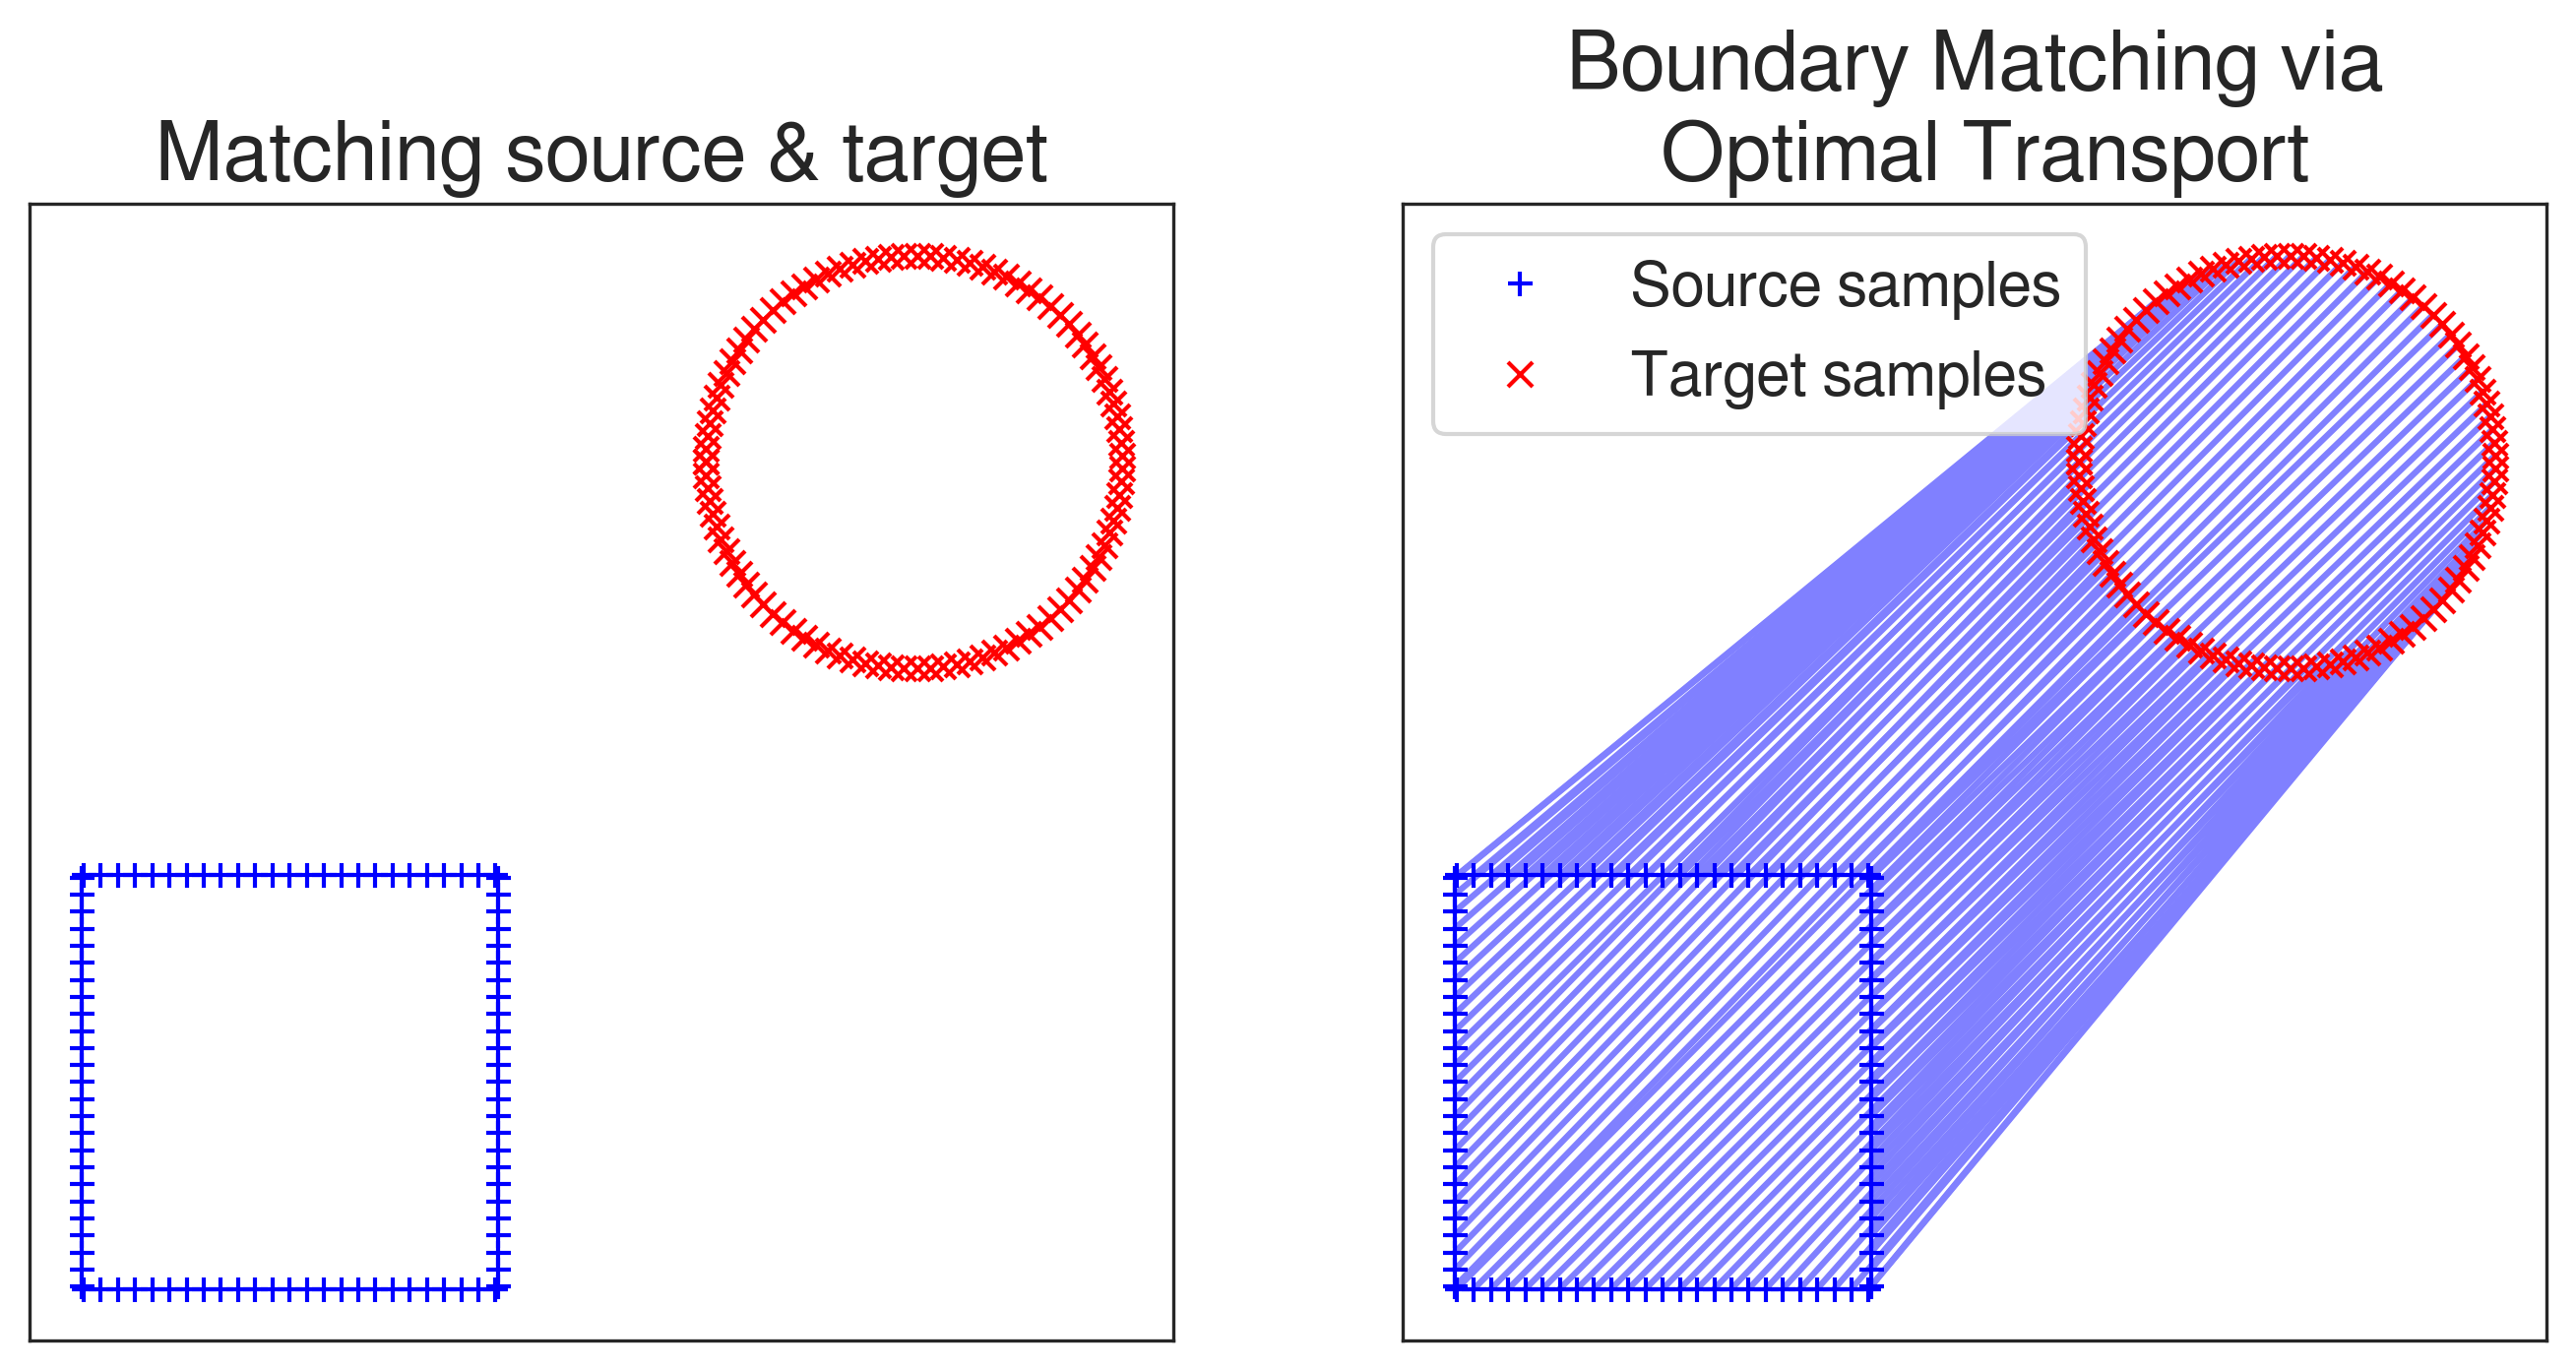

In [49]:
plan = comp_match_plan(square, circle)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5),  dpi=300)

ax1.plot(square[:, 0], square[:, 1], '+b', label='Source samples')
ax1.plot(circle[:, 0], circle[:, 1], 'xr', label='Target samples')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Matching source & target', fontsize=20)

ot.plot.plot2D_samples_mat(square, circle, plan, c=[.5, .5, 1])
ax2.plot(square[:, 0], square[:, 1], '+b', label='Source samples')
ax2.plot(circle[:, 0], circle[:, 1], 'xr', label='Target samples')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Boundary Matching via\n Optimal Transport', fontsize=20)

# plt.figure(figsize=(5, 5), dpi=300) # so that the figure is not skewed 
# ot.plot.plot2D_samples_mat(square, circle, plan, c=[.5, .5, 1])
# plt.plot(square[:, 0], square[:, 1], '+b', label='Source samples')
# plt.plot(circle[:, 0], circle[:, 1], 'xr', label='Target samples')
plt.legend(loc=0)
plt.show()


fig.savefig('figures/interpolate.svg', dpi=300, bbox_inches='tight')

In [16]:
print(np.unique(interps[0][:, 0]), np.unique(interps[0][:, 1]))

[0 1 2] [0 1 2]


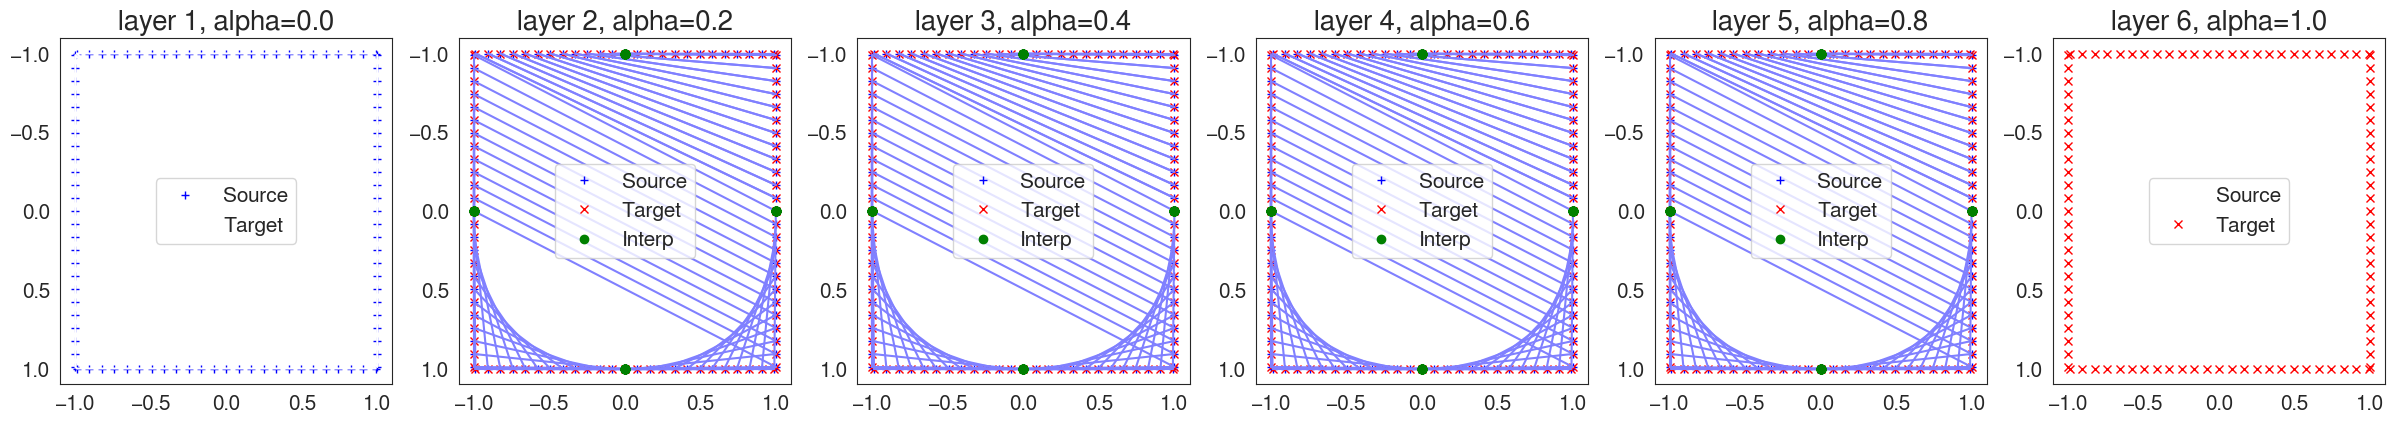

In [27]:
interps = interpolate(square, square, anisotropy=5)
fig = disp_interp(square, 
                  square, 
                  interps, 
                  plan=plan,
                  show_match=True
                 )
plt.show()


### Task 2. Alignment.

- Baseline: cellpose [`stitch3D`](https://github.com/MouseLand/cellpose/blob/706bae639a30cdd0a5e4966f33f28da08a200b4d/cellpose/utils.py#L358-L385) - argmax. IoU alignment through each adjacent layers ($i$ & $i+1$) <br>
- Our implementations:
    - Consensus alignment of adjacent $n$ slices, take argmax. IoU candidate label on each z-slice: ($i-n,\dots, i+n$).<br>
      `consensus_stitch`, `match_multi_lbls`
    - TODO: 1-to-n / n-to-1 mapping for controversial situations. See example below:
      ```
      --- ---
      | |_| |
      |_____|
      ```
      unfinished implementation: `match_lbls`
 

Util functions for label matching & IoU calculations:

In [17]:
def _calc_iou(masks, lbls, intersect=None):
    """
    Calculate intersection of union (IoU) volume among lbls in masks
    """
    if not intersect:
        intersect = np.logical_and.reduce([
            (mask == lbl).ravel()
             for (mask, lbl) in zip(masks, lbls)
        ]).sum()
        
    union = np.logical_or.reduce([
        (mask == lbl).ravel()
        for (mask, lbl) in zip(masks, lbls)     
    ]).sum()

    return intersect / union


def match_lbls(source_mask, target_mask, sc_lbl, thld):
    """
    Find matched labels with 1-to-n / n-to-1 mapping 
    (multi-layer isn't implemented in this function yet)
    """
    coords = np.nonzero(source_mask == sc_lbl)
    cand_lbls, counts = np.unique(adj_mask[coords], return_counts=True)  # Candidate labels
    
    if len(cand_lbls) == 0:
        tg_lbls == [] if cand_lbls[0] == 0 else cand_lbls[0]
    else:
        # First check whether argmax matched lbl has IoU exceeding threshold
        cand_lbls = cand_lbls[1:]
        counts = counts[1:]
        
        max_intersect = counts.max()
        tg_lbl = cand_lbls[counts.argmax()]
        max_union = np.logical_or(
            source_mask == sc_lbl.ravel(),
            target_mask == tg_lbl.ravel()
        )
        
        iou = max_intersect / max_union
        
        if iou < thld:
            tg_lbls = []
        else:
            ious = [
                _calc_iou([source_mask, target_mask], [sc_lbl, tg_lbl], intersect)
                for (tg_lbl, intersect) in zip(cand_lbls, intersect)
            ]
            
            tg_lbls = [iou for iou in ious if iou >= thld]
            
    return tg_lbls
 

def match_multi_lbls(source_mask, target_masks, sc_lbl, thld):
    """
    Find matched labels across muliple layers (source_mask <--> list of target_mask)
    take consensus IoU
    """
    coords = np.nonzero(source_mask == sc_lbl)
    tg_lbls = []
    
    for target_mask in target_masks:
        cand_lbls, counts = np.unique(target_mask[coords], return_counts=True)
        
        if len(cand_lbls) == 1 and cand_lbls[0] != 0:
            tg_lbls.append(cand_lbls[0])
        elif len(cand_lbls) > 1:
            cand_lbls = cand_lbls[1:]
            counts = counts[1:]
            tg_lbl = cand_lbls[counts.argmax()]
            
            tg_lbls.append(tg_lbl)
            
    masks, lbls = deepcopy(target_masks), deepcopy(tg_lbls)
    masks.append(source_mask)
    lbls.append(sc_lbl)
    
    ious = _calc_iou(masks, lbls)
    if ious < thld:
        tg_lbls = []
        
    return tg_lbls


Main functions for alignment / stitching:

In [18]:
def _stitch_slices(masks, stitched_masks, i, n_slice, curr_lbl, thld):
    """
    Perform multi-layer stitching / alignment through layer i & its up/down 
    n_slice neighbors (i-n_slices, ..., i+n_slices) window. Assign instances
    to the same labels if consensus IoU exceeds threshold 
    
    
    Parameters
    ----------
    masks : np.ndarray
        Independent 2D instance segmentations before alignment
        (dim: (Depth, H, W))
        
    stitched_masks : np.ndarray
        Stitched instance segmentations after current layer alignemnt
        (dim: (Depth, H, W))
        
    i : int
        Index of layer of interest
        
    n_slice : int
        Number of neighbors to look up / down
        
    curr_lbl : int
        New label value for current layer alignment
        
    thld : float
        IoU threshold
        
    Returns
    -------
    curr_lbl : int
        next available new label value
    
    (stitched_masks is updated through original copy, no need to return)
    
    """
    zmax = len(masks)
    source_mask = masks[i]
    adj_idxs = list(range(max(0, i-n_slice), max(0, i))) + \
           list(range(min(zmax, i+1), min(zmax, n_slice+i+1)))
    
    target_masks = list(masks[adj_idxs])
    lbls = get_lbls(source_mask)
    
    
    # Align labels with [i-n_slices,...,i+n_slices] window
    # Direct label assignment if 
    #     (1). Current label is already assigned
    #     (2). Aligned labels of current label are already assigned 
    # during previous alignment
    
    for lbl in lbls:
        # (1). Check whether label is already assigned
        coords = np.nonzero(source_mask == lbl)
        if stitched_masks[i][coords].sum() != 0:
            continue
            
        tg_lbls = match_multi_lbls(source_mask, target_masks, lbl, thld)
        
        if len(tg_lbls) != 0:
            # (2). Check whether aligned labels are alredy assigned
            new_lbl = curr_lbl
            for idx, tg_mask, tg_lbl in zip(adj_idxs, target_masks, tg_lbls):
                tg_coords = np.nonzero(tg_mask == tg_lbl) 
                vals = stitched_masks[idx][tg_coords]
                if vals.sum() != 0:
                    new_lbl = np.unique(vals)[0]
            
            for idx, tg_mask, tg_lbl in zip(adj_idxs, target_masks, tg_lbls):
                tg_coords = np.nonzero(tg_mask == tg_lbl) 
                stitched_masks[i][coords] = new_lbl
                stitched_masks[idx][tg_coords] = new_lbl    
                
                if new_lbl == curr_lbl:
                    curr_lbl += 1

    return curr_lbl


def consensus_stitch(masks, n_slice=1, thld=0.4, verbose=False):
    """
    Perform onsensus stitching with adjacent up & down z-slices filtered
    by IoU threshold for aligned labels across multi-layers
    
    Parameters
    ----------
    masks : np.ndarray
        Independent 2D instance segmentations before alignment
        (dim: (Depth, H, W))
        
    n_slice : int
        Number of neighbors to look up / down
        
    thld : float
        IoU threshold
    
    Returns
    -------
    stitched_masks : np.ndarray
        Stitched instance segmentations after current layer alignemnt
        (dim: (Depth, H, W))
    
    """
    assert len(masks) >= n_slice+1, \
        "Too few z-stacks to stitch, please choose lower n_slice <= {}".format(zmax)
    
    if not isinstance(masks, np.ndarray):
        masks = np.asarray(masks)
    
    zmax = len(masks)
    stitched_masks = np.zeros_like(masks)
    max_lbl = get_lbls(np.array(masks))[-1] 
    curr_lbl = max_lbl + 1
    
    # (1). Forward
    if verbose:
        print('Stitching forward from middle z layer || --> ...')
    for i in range(zmax//2, zmax):
        if masks[i].sum() > 0: # not `empty` edge layer
            curr_lbl = _stitch_slices(masks, stitched_masks, i, n_slice, curr_lbl, thld)
      
    # (2). Backward
    if verbose:
        print('Stitching backward from middle z layer <-- || ...')
    for i in range(zmax//2-1, -1, -1):
        if masks[i].sum() > 0: # not `empty` edge layer
            curr_lbl = _stitch_slices(masks, stitched_masks, i, n_slice, curr_lbl, thld)
                
    stitched_masks[stitched_masks != 0] -= max_lbl
                
    return stitched_masks
                

---

Load raw cellpose 2D segmentations without sitching

In [ ]:
%ls -al ../data/

In [ ]:
data_path = '../data/'

In [ ]:
preds = np.load(os.path.join(data_path, 'sample_raw_preds.npy'))
# preds.shape

(1). Baseline: cellpose `stitch3D`

In [ ]:
cp_stitch_preds = cp_utils.stitch3D(
    masks=list(preds), 
    stitch_threshold=0.4
) 

cp_stitch_preds = np.asarray(cp_stitch_preds)
# cp_stitch_preds.shape 

(2). Our consensus stitching

In [ ]:
n_slice = 1  # aligning through (i-1,i,i+1)
cons_preds = consensus_stitch(preds, n_slice=n_slice, thld=0.4, verbose=True)

(3). Benchmark. <br>
Criteria: # cells, volumes, depth of each instance

Util functions:

In [19]:
def calc_vols(pred):
    """
    Calculate volumes of each mask from predictions
    """
    lbls = get_lbls(pred)
    vols = [(pred == lbl).sum() for lbl in lbls]
    return vols


def calc_depth(masks):
    """
    Calculate z-layer depth of predictions
    """
    assert masks.ndim == 3, "Mask predictions must be 3D to calculate depth"
    
    lbls = get_lbls(masks)
    depths = np.vectorize(
        lambda lbl: 
        np.diff(np.nonzero(masks == lbl)[0][[0, -1]])[0]
    )(lbls)

    return depths

In [ ]:
# (1). number of cells

print(
    "Number of cells \n (1). stitch3D: {0}\n (2). Consensus stitching: {1}".format(
        len(get_lbls(cp_stitch_preds)),
        len(get_lbls(cons_preds))
    )
)
      

In [ ]:
# (2). Volumes
cp_vols = calc_vols(cp_stitch_preds)
cons_vols = calc_vols(cons_preds)


print(
    "Cell avg. volume \n (1). stitch3D: {0}\n (2). Consensus stitching: {1}".format(
        np.round(np.mean(cp_vols), 2),
        np.round(np.mean(cons_vols), 2)
    )
)     

In [ ]:
# (3). Depth
cp_depths = calc_depth(cp_stitch_preds)
cons_depths = calc_depth(cons_preds)


print(
    "Cell avg. depth \n (1). stitch3D: {0}\n (2). Consensus stitching: {1}".format(
        np.round(np.mean(cp_depths), 2),
        np.round(np.mean(cons_depths), 2)
    )
)
      

---

### Task 3 (I). Smoothing

Util function for interpolation:

In [15]:
from skimage.morphology import binary_dilation

In [20]:
def full_interpolate(masks, anisotropy=2, verbose=False):
    """
    Interpolating between all adjacent z-layers
    
    Parameters
    ----------
    masks : np.ndarray
        layers of 2D predictions
        (dim: (Depth, H, W))
        
    anisotropy : int
        Ratio of sampling rate between xy-axes & z-axis
        
    Returns
    -------
    interp_masks : np.ndarray
        interpolated masks
        (dim: (Depth * anisotropy - (anisotropy-1), H, W))
    
    """
    interp_masks = np.zeros((
        len(masks) + (len(masks)-1)*(anisotropy-1),
        masks.shape[1],
        masks.shape[2]
    ))
    
    idx = 0
    for i, sc_mask in enumerate(masks[:-1]):
        if verbose and i % 20 == 0:
            print('Interpolating layer {} & {}...'.format(i, i+1))
        tg_mask = masks[i+1]
        interps = interp_layers(sc_mask, tg_mask, anisotropy=anisotropy)
        interp_masks[idx:idx+anisotropy+1] = interps
        idx += anisotropy
        
    return interp_masks
        

def interp_layers(sc_mask, tg_mask, anisotropy=2):
    """
    Interpolating adjacent z-layers
    """
    
    def _dilation(coords, lims):
        y, x = coords
        ymax, xmax = lims
        dy, dx = np.meshgrid(np.arange(y-2, y+3), np.arange(x-2, x+3), indexing='ij')
        dy, dx = dy.flatten(), dx.flatten()
        mask = np.logical_and(
            np.logical_and(dy >= 0, dx >= 0), 
            np.logical_and(dy < ymax, dx < xmax)
        )
        return dy[mask], dx[mask]
    
    shape = sc_mask.shape
    sc_contour = get_contours(sc_mask)
    tg_contour = get_contours(tg_mask)

    # Boundary condition: if empty on source / target label
    # align the empty slice w/ mass centers to represent instance endings
    sc_dummy = np.zeros_like(sc_mask)
    tg_dummy = np.zeros_like(tg_mask)
    if not np.intersect1d(get_lbls(sc_contour), get_lbls(tg_coutour)).size:
        if (sc_contour.sum() == tg_contour.sum() == 0) or (np.logical_and(sc_mask, tg_mask).sum() > 0):
            return np.zeros_like(sc_mask)
        
        get_mask_center = lambda x: (
            np.round(np.nonzero(x)[0].sum() / x.sum()).astype(np.uint16),
            np.round(np.nonzero(x)[1].sum() / x.sum()).astype(np.uint16)
        )
        for lbl in get_lbls(sc_contour):
            yc, xc = _dilation(get_mask_center(sc_mask == lbl), sc_mask.shape)
            tg_dummy[yc, xc] = lbl
        for lbl in get_lbls(tg_contour):
            yc, xc = _dilation(get_mask_center(tg_mask == lbl), tg_mask.shape)
            sc_dummy[yc, xc] = lbl
        sc_contour += sc_dummy
        tg_contour += tg_dummy

    joint_lbls = np.intersect1d(
        get_lbls(sc_contour),
        get_lbls(tg_contour)
    )

    interp_masks = np.zeros((
        anisotropy+1,      # num. interpolated layers
        len(joint_lbls),   # num. individual masks
        shape[0],          # x
        shape[1]           # y
    ))

    for i, lbl in enumerate(joint_lbls):
        sc_ct = (sc_contour== lbl).astype(np.uint8)
        tg_ct = (tg_contour == lbl).astype(np.uint8)

        sc_coord = mask_to_coord(sc_ct)
        tg_coord = mask_to_coord(tg_ct)

        plan = comp_match_plan(sc_coord, tg_coord)
        interp_coords = interpolate(sc_coord, tg_coord, anisotropy=anisotropy)
        interps = [
            ndi.binary_fill_holes(connect_boundary(interp, shape)) * lbl
            for interp in interp_coords
        ]

        interp_masks[1:-1, i,...] = interps

    interp_masks = interp_masks.max(1)
    interp_masks[0] = sc_mask
    interp_masks[-1] = tg_mask

    return interp_masks

### Task 3 (II). Interpolation

#### Full interpolation to all adjacent layers

Load stitched data for interpolation:

In [6]:
data_path = 'results/ovules_subsampled/pipeline/cellstitch/'

Visualize sample predictions & its contours:

In [7]:
sample_pred = np.load(os.path.join(data_path, 'N_522_final_crop_ds2.npy'))
sample_pred.shape

(185, 810, 935)

In [8]:
layer_src = 80
layer_dst = 82

contour_src, contour_dst = get_contours(sample_pred[layer_src]), get_contours(sample_pred[layer_dst])

In [9]:
common_lbls = np.intersect1d(
    get_lbls(sample_pred[layer_src]),
    get_lbls(sample_pred[layer_dst])
)

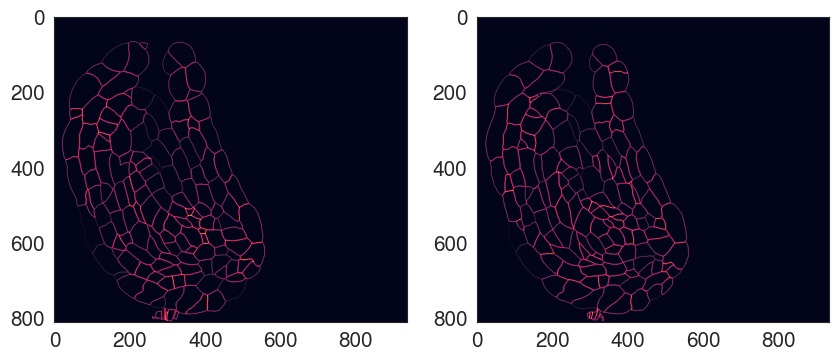

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(contour_src)
ax2.imshow(contour_dst)

plt.show()

In [10]:
sample_lbl = 225

sample_contour_src = (contour_src == sample_lbl).astype(np.uint8)
sample_contour_dst = (contour_dst == sample_lbl).astype(np.uint8)

sample_coords_src = mask_to_coord(sample_contour_src)
sample_coords_dst = mask_to_coord(sample_contour_dst)

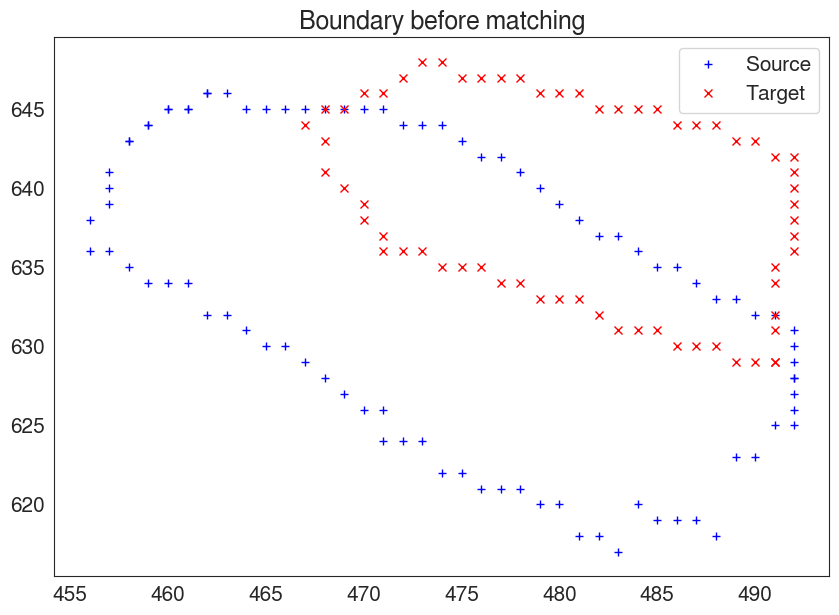

In [76]:
# (3). Visualize contours
plt.figure(figsize=(10, 7))
plt.plot(sample_coords_src[:, 1], sample_coords_src[:, 0][::-1], '+b', label='Source')
plt.plot(sample_coords_dst[:, 1], sample_coords_dst[:, 0][::-1], 'xr', label='Target')

plt.title("Boundary before matching")
plt.legend()
plt.show()

In [15]:
# reference: 
# https://pythonot.github.io/_modules/ot/plot.html#plot2D_samples_mat
def disp_match(xs, xt, G, ax, thr=1e-8, **kwargs):
    r""" Plot matrix :math:`\mathbf{G}` in 2D with lines using alpha values

    Plot lines between source and target 2D samples with a color
    proportional to the value of the matrix :math:`\mathbf{G}` between samples.


    Parameters
    ----------
    xs : ndarray, shape (ns,2)
        Source samples positions
        
    b : ndarray, shape (nt,2)
        Target samples positions
    
    G : ndarray, shape (na,nb)
        OT matrix
    
    ax : AxesSubplot
        matplotlib subplot axis
    
    thr : float, optional
        threshold above which the line is drawn
    
    **kwargs : dict
        parameters given to the plot functions (default color is black if
        nothing given)
    """

    if ('color' not in kwargs) and ('c' not in kwargs):
        kwargs['color'] = 'k'
    mx = G.max()
    for i in range(xs.shape[0]):
        for j in range(xt.shape[0]):
            if G[i, j] / mx > thr:
                ax.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                        alpha=G[i, j] / mx, **kwargs)
                
    return ax


def disp_interp(sc_coord, tg_coord, interps, plan, show_match=False):
    """Visualize interpotations"""
    n_layers = len(interps) + 2
    alphas = np.linspace(0, 1, n_layers)
    
    fig, axes = plt.subplots(1, n_layers, figsize=(n_layers*5, 4.5), dpi=300)
    
    for i, ax in enumerate(axes):
        sc_color = 'w' if i == n_layers-1 else '+b'
        tg_color = 'w' if i == 0 else 'xr'
        
        ax.plot(sc_coord[:, 0], sc_coord[:, 1], sc_color, label='Source')
        ax.plot(tg_coord[:, 0], tg_coord[:, 1], tg_color, label='Target')
        if 0 < i < n_layers-1: 
            if show_match:
                ax = disp_match(sc_coord, tg_coord, plan, ax=ax, c=[.5, .5, 1])
            ax.plot(interps[i-1][:, 0], interps[i-1][:, 1], 'og', label='Interp')
            
        for line in ax.get_lines():
            xdata, ydata = line.get_xdata(), line.get_ydata()
            line.set_xdata(ydata)
            line.set_ydata(xdata)
            line.axes.relim()
            line.axes.autoscale_view()
            
        ax.axes.invert_yaxis()
        ax.legend(loc=0)
        
        if i == 0:
            ax.set_title(r'layer $z$, $\alpha={0}$'.format(np.round(alphas[i], 2)), fontsize=20)
        elif i == n_layers-1:
            ax.set_title(r'layer $z+1$, $\alpha={0}$'.format(np.round(alphas[i], 2)), fontsize=20)
        else:
            ax.set_title(r"layer $z_{0}'$, $\alpha={1}$".format(i, np.round(alphas[i], 2)), fontsize=20)

    return fig

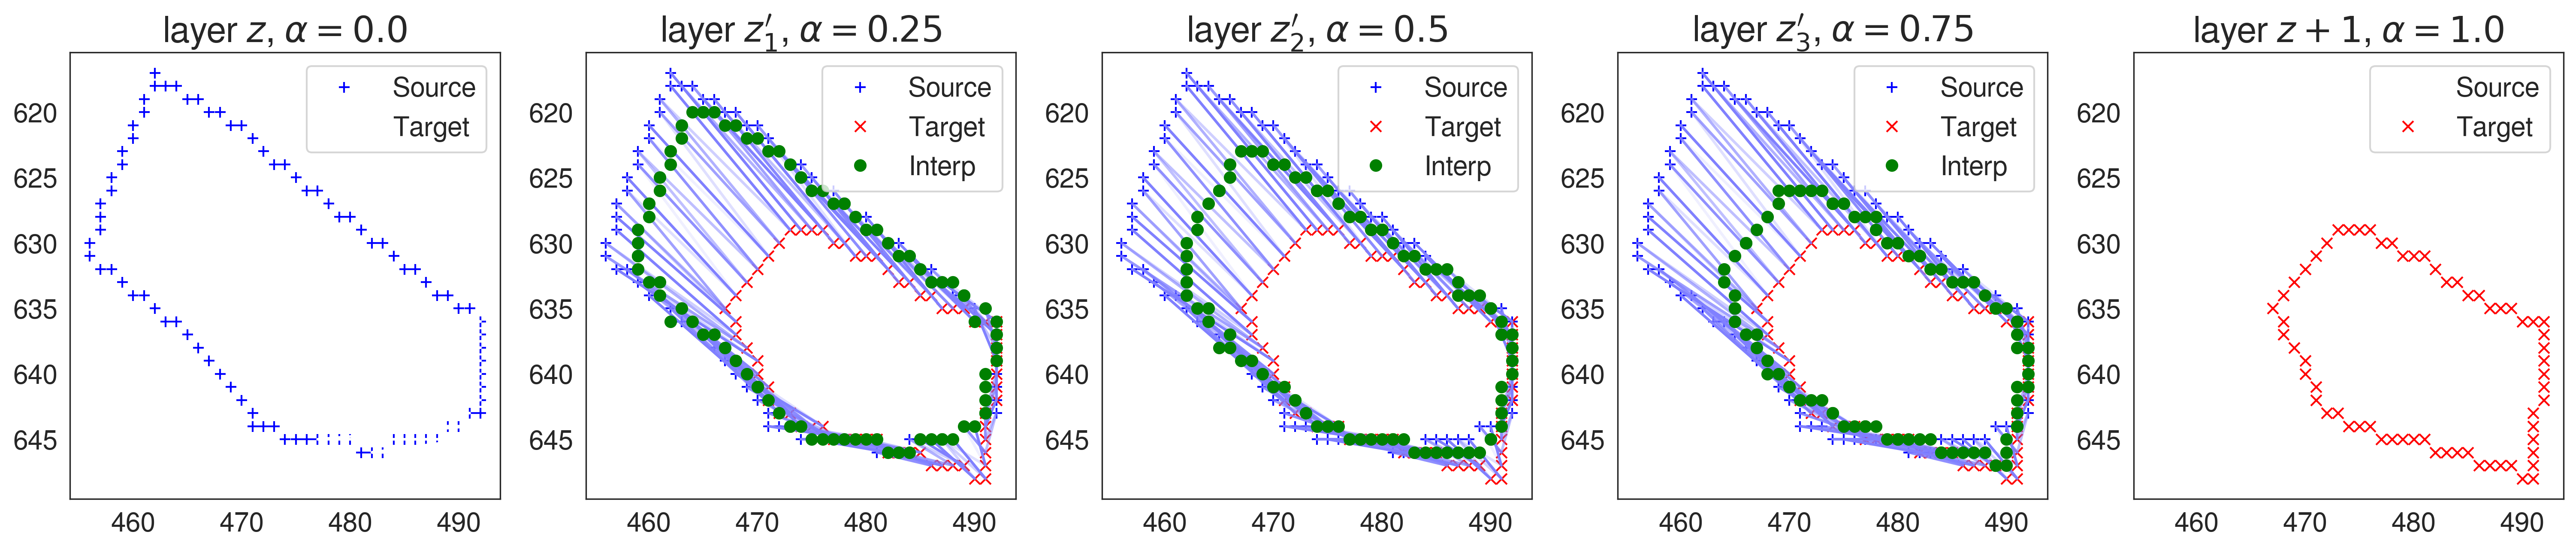

In [16]:
anisotropy = 4

plan = comp_match_plan(sample_coords_src, sample_coords_dst)
interps = interpolate(sample_coords_src, sample_coords_dst, anisotropy)

# Visualize matchings
fig = disp_interp(sample_coords_src,
                  sample_coords_dst,
                  interps,
                  plan=plan,
                  show_match=True
                 )

In [17]:
fig.savefig('figures/fig3_interp_diagram.png', bbox_inches = "tight", dpi=300)

Example:<br>
Boundary matching & OT with a sample label from z-slices 9 & 10.<br>
 - Single interpolated layer (`anisotropy=2`). <br>First, print common labels from those 2 layers:

In [ ]:
np.intersect1d(
    get_lbls(sample_contours[9]),
    get_lbls(sample_contours[10])
)

In [ ]:
lbl = 61

# (1). Calculate coords
sample_contour1 = (sample_contours[9] == lbl).astype(np.uint8)
sample_contour2 = (sample_contours[10] == lbl).astype(np.uint8)


# (2). Transform coords for OT (Note: dim = (N, 2))
sample_coord1 = mask_to_coord(sample_contour1)
sample_coord2 = mask_to_coord(sample_contour2)

# (3). Visualize contours
plt.figure(figsize=(10, 10))
plt.plot(sample_coord1[:, 1], sample_coord1[:, 0][::-1], '+b', label='Source')
plt.plot(sample_coord2[:, 1], sample_coord2[:, 0][::-1], 'xr', label='Target')

plt.title("Boundary before matching")
plt.legend()
plt.show()

Then, compute matching & interpolations

In [ ]:
anisotropy = 2

plan = comp_match_plan(sample_coord1, sample_coord2)
interps = interpolate(sample_coord1, sample_coord2, anisotropy)

# Visualize matchings
fig = disp_interp(sample_coord1,
                  sample_coord2,
                  interps,
                  plan=plan,
                  show_match=True
                 )

# fig.savefig('../figures/sample_cell_ot1.jpg')

Lastly, connect interpolated boundary & fill in masks

In [ ]:
# Applied boundary connection: working
connected_mask = connect_boundary(interps[0], sample_contour1.shape)

plt.figure(figsize=(6, 6))
plt.imshow(ndi.binary_fill_holes(connected_mask))
plt.show()

- Full interpolation to all original image stack with self-defined `anisotropy`

In [15]:
import time

In [ ]:
interps = full_interpolate(sample_stitched, anisotropy=3)
print('Orig. dim: {}'.format(sample_stitched.shape))
print('Interpolated dim: {}'.format(interps.shape))

- Experiment: ovules & atas data:

In [23]:
ovules_path = 'results/ovules/ct_stitched/'
fnames = sorted([
    f for f in os.listdir(ovules_path)
    if f[-3:] == 'npy'
])
ovules_mask = np.load(os.path.join(ovules_path, fnames[0]))


In [27]:
t0 = time.perf_counter()
ovules_interp = full_interpolate(ovules_mask, verbose=True)
t1 = time.perf_counter()

Interpolating layer 0 & 1...
Interpolating layer 20 & 21...
Interpolating layer 40 & 41...
Interpolating layer 60 & 61...
Interpolating layer 80 & 81...
Interpolating layer 100 & 101...
Interpolating layer 120 & 121...
Interpolating layer 140 & 141...
Interpolating layer 160 & 161...
Interpolating layer 180 & 181...
Interpolating layer 200 & 201...
Interpolating layer 220 & 221...
Interpolating layer 240 & 241...
Interpolating layer 260 & 261...
Interpolating layer 280 & 281...
Interpolating layer 300 & 301...


In [ ]:
# Save interpolated results
# np.save(os.path.join(data_path, 'sample_interp.npy'), interps)